In [1]:
import spectral

# Path to your .hdr file
hdr_path = "../data/CRISM_MTRDR/frt000105d4_07_if164j_mtr3.hdr"

img = spectral.open_image(hdr_path)
# This ‘img’ is a Spectral Python image object, which can be used to read reflectance data

print(img.shape)   # Typically (rows, cols, bands), e.g. (500, 640, 545)

(635, 727, 489)


In [2]:
print(img)
print(img.metadata)

	Data Source:   '././../data/CRISM_MTRDR/frt000105d4_07_if164j_mtr3.img'
	# Rows:            635
	# Samples:         727
	# Bands:           489
	Interleave:        BSQ
	Quantization:  32 bits
	Data format:   float32
{'description': 'ENVI File, Created [Mon Jul 13 11:34:42 2020]', 'samples': '727', 'lines': '635', 'bands': '489', 'header offset': '0', 'file type': 'ENVI Standard', 'data type': '4', 'interleave': 'bsq', 'sensor type': 'Unknown', 'byte order': '0', 'map info': ['MRO Mars Equirectangular [IAU 2000] [-25.00N; 0.00E]', '1.0000', '1.0000', '6539835.7000', '-1552819.6000', '1.8000000000e+01', '1.8000000000e+01', 'D_Mars_2000_IAU_IAG_custom_sphere_lat25', 'units=Meters'], 'projection info': ['17', '3392593.6', '-25.000000', '0.000000', '0.0', '0.0', 'D_Mars_2000_IAU_IAG_custom_sphere_lat25', 'MRO Mars Equirectangular [IAU 2000] [-25.00N; 0.00E]', 'units=Meters'], 'coordinate system string': ['PROJCS["MRO Mars Equirectangular [IAU 2000] [-25.00N; 0.00E]"', 'GEOGCS["GCS_Mars_200

/home/samuil/miniconda3/envs/hyperenv/lib/python3.9/site-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


ImageView object:
  Display bands       :  (50, 30, 10)
  Interpolation       :  <default>
  RGB data limits     :
    R: [np.float64(0.1653580665588379), np.float64(65535.0)]
    G: [np.float64(0.16490492224693298), np.float64(65535.0)]
    B: [np.float64(0.07996784150600433), np.float64(65535.0)]

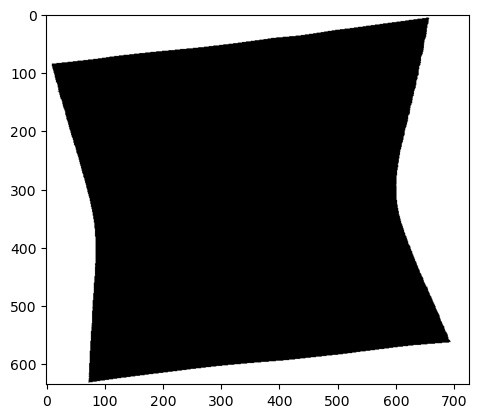

In [3]:
# For example, choose some band indices. 
# The actual band indices to pick can be trial-and-error or guided by known wavelength positions.
# E.g., let's say we pick band 50 (near ~650 nm?), band 30 (~560 nm?), band 10 (~460 nm?)

spectral.imshow(img, (50, 30, 10))


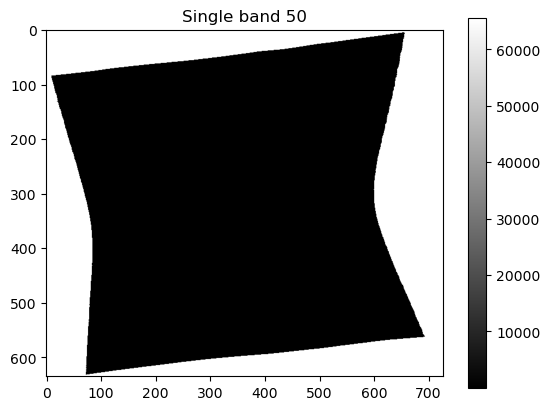

In [4]:
band_idx = 50
band_data = img.read_band(band_idx)

import matplotlib.pyplot as plt
plt.imshow(band_data, cmap='gray')
plt.colorbar()
plt.title(f"Single band {band_idx}")
plt.show()


In [5]:
band_data = img.read_band(50)
print("Min:", band_data.min())
print("Max:", band_data.max())


Min: 0.16535807
Max: 65535.0


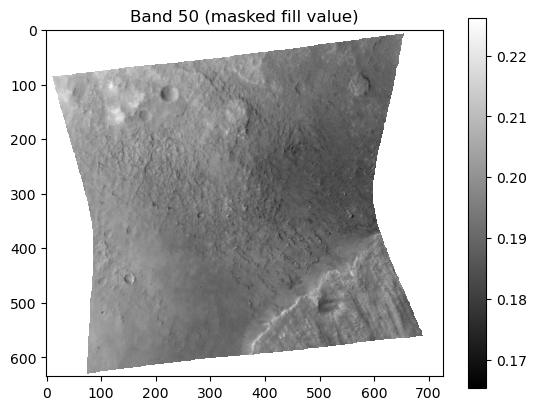

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Read the band again
band_data = img.read_band(50)

# Mask the fill value
fill_value = 65535.0
band_data_masked = np.where(band_data == fill_value, np.nan, band_data)

# Display with corrected scaling
plt.imshow(band_data_masked, cmap='gray')
plt.colorbar()
plt.title("Band 50 (masked fill value)")
plt.show()


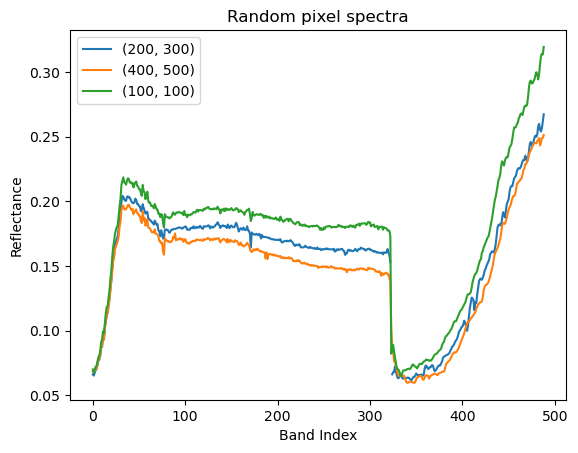

In [7]:
data = img.load().astype(np.float32)  # Load full cube as float
data[data == 65535.0] = np.nan        # Mask fill value

import matplotlib.pyplot as plt
for (r, c) in [(200, 300), (400, 500), (100, 100)]:
    spectrum = data[r, c, :]
    plt.plot(spectrum, label=f"({r}, {c})")

plt.xlabel("Band Index")
plt.ylabel("Reflectance")
plt.title("Random pixel spectra")
plt.legend()
plt.show()


In [8]:
cube = img.load().astype(np.float32)
cube[cube == 65535.0] = np.nan

# Reshape: (rows, cols, bands) -> (num_pixels, bands)
n_rows, n_cols, n_bands = cube.shape
reshaped = cube.reshape(-1, n_bands)

# Keep only valid pixels (where first band is not nan)
valid_mask = ~np.isnan(reshaped[:, 0])
valid_pixels = reshaped[valid_mask]
print(f"Valid pixels: {valid_pixels.shape}")


Valid pixels: (315782, 489)


In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Filter out any row with NaNs (not just band 0)
valid_pixels_clean = valid_pixels[~np.isnan(valid_pixels).any(axis=1)]

# Dimensionality reduction with PCA
pca = PCA(n_components=30)
pixels_pca = pca.fit_transform(valid_pixels_clean)

# Normalize for clustering
scaler = StandardScaler()
pixels_scaled = scaler.fit_transform(pixels_pca)

# Run KMeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
labels = kmeans.fit_predict(pixels_scaled)

print("Cluster label counts:", np.bincount(labels))

Cluster label counts: [64007 27501 48599 69411 17033]


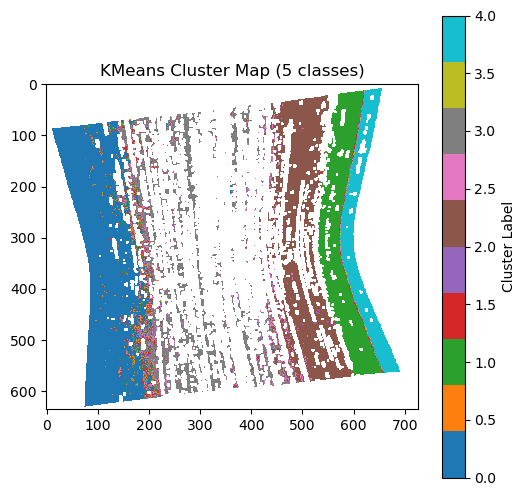

In [10]:
# Create full label image (flattened)
cluster_image_flat = np.full((n_rows * n_cols), np.nan)

# Find fully valid rows again (same filtering as before)
valid_mask_all = ~np.isnan(valid_pixels).any(axis=1)

# Fill in cluster labels at valid positions
cluster_image_flat[valid_mask] = np.nan  # reset
cluster_image_flat[np.where(valid_mask)[0][valid_mask_all]] = labels

# Reshape to (rows, cols)
cluster_image = cluster_image_flat.reshape(n_rows, n_cols)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.imshow(cluster_image, cmap='tab10')  # tab10 gives distinct colors for up to 10 clusters
plt.title("KMeans Cluster Map (5 classes)")
plt.colorbar(label="Cluster Label")
plt.show()

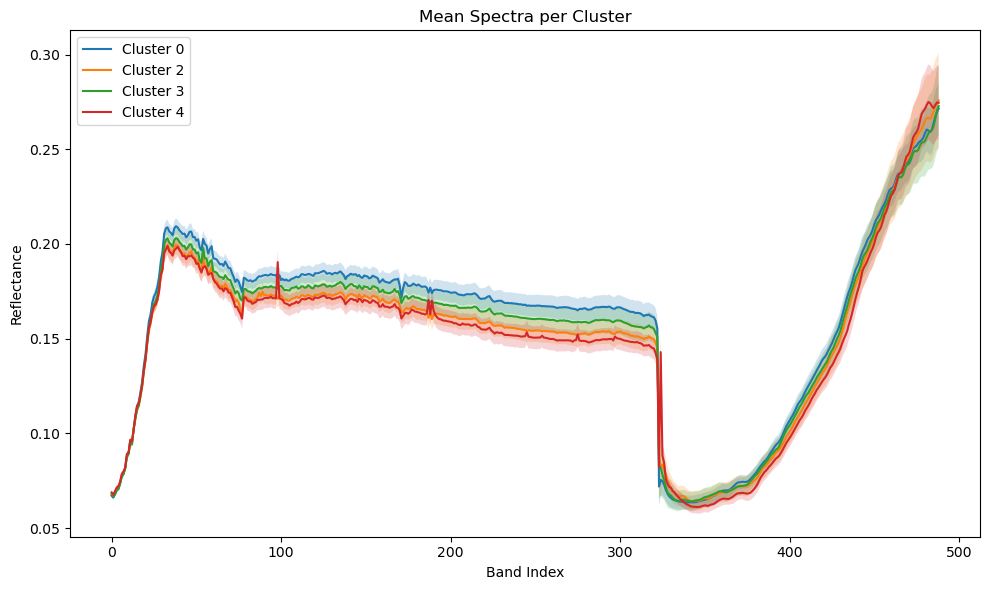

In [11]:
# Step 1: Create list to hold spectra per cluster
cluster_spectra = [[] for _ in range(n_clusters)]

# Step 2: Get the original flat valid mask (used for clustering)
valid_mask_flat = ~np.isnan(valid_pixels).any(axis=1)

# Step 3: Create stricter mask to clean out garbage pixels
valid_mask_strict = (
    (~np.isnan(valid_pixels).any(axis=1)) &
    (~(valid_pixels == 65535.0).any(axis=1)) &
    (~(valid_pixels < 0).any(axis=1)) &
    (~(valid_pixels > 1.0).any(axis=1))
)

# Step 4: Apply strict mask to get cleaned pixels and labels
valid_pixels_clean = valid_pixels[valid_mask_strict]
labels_clean = labels[valid_mask_strict[valid_mask_flat]]

# Step 5: Assign spectra to their cluster
for i, label in enumerate(labels_clean):
    cluster_spectra[label].append(valid_pixels_clean[i])

# Convert to numpy arrays
cluster_spectra = [np.array(s) for s in cluster_spectra]

# Plot mean + std for each cluster
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, spectra in enumerate(cluster_spectra):
    if len(spectra) == 0:
        continue
    mean_spectrum = np.nanmean(spectra, axis=0)
    std_spectrum = np.nanstd(spectra, axis=0)
    plt.plot(mean_spectrum, label=f"Cluster {i}")
    plt.fill_between(range(len(mean_spectrum)), mean_spectrum - std_spectrum, mean_spectrum + std_spectrum, alpha=0.2)

plt.xlabel("Band Index")
plt.ylabel("Reflectance")
plt.title("Mean Spectra per Cluster")
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# Reuse your cleaned pixel list and labels
X = valid_pixels_clean  # shape: [N, 489]
y = labels_clean        # shape: [N]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique classes:", np.unique(y))

X shape: (182524, 489)
y shape: (182524,)
Unique classes: [0 2 3 4]


In [13]:
# from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# print("Train:", X_train.shape, "Val:", X_val.shape)

import numpy as np
from sklearn.model_selection import train_test_split

# Relabel y to be 0–(num_classes-1)
unique_classes = np.unique(y)
class_mapping = {old: new for new, old in enumerate(unique_classes)}
y_mapped = np.array([class_mapping[label] for label in y])

# Train/test split using remapped labels
X_train, X_val, y_train, y_val = train_test_split(
    X, y_mapped, test_size=0.2, stratify=y_mapped, random_state=42
)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Labels in use:", np.unique(y_train))


Train shape: (146019, 489)
Val shape: (36505, 489)
Labels in use: [0 1 2 3]


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

class SpectralDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SpectralDataset(X_train, y_train)
val_dataset = SpectralDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class SpectralCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SpectralCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # shape: [B, 1, 489]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)    # shape: [B, 32, 1]
        x = x.squeeze(-1)   # shape: [B, 32]
        x = self.fc(x)
        return x


In [16]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpectralCNN(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(5):  # Start with 5 epochs, we can scale up later
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    acc = correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Val Acc: {acc:.4f}")


Epoch 1, Loss: 1266.8284, Val Acc: 0.3865
Epoch 2, Loss: 1194.3525, Val Acc: 0.5679
Epoch 3, Loss: 1034.5205, Val Acc: 0.6081
Epoch 4, Loss: 977.6666, Val Acc: 0.5896
Epoch 5, Loss: 926.6823, Val Acc: 0.6042


In [17]:
# # Ensure model is in eval mode
# model.eval()

# # Convert full valid pixel set to tensor
# X_all = torch.tensor(valid_pixels_clean, dtype=torch.float32).to(device)

# # Predict in batches
# with torch.no_grad():
#     X_all = torch.tensor(valid_pixels_clean, dtype=torch.float32).to(device)
#     logits = model(X_all)  # model adds unsqueeze inside
#        # pass directly to model

#     #logits = model(X_all.unsqueeze(1))  # Add channel dim
#     predictions = torch.argmax(logits, dim=1).cpu().numpy()  # shape [N]

In [18]:
from torch.utils.data import DataLoader, TensorDataset

# Wrap in a TensorDataset and DataLoader
X_all_tensor = torch.tensor(valid_pixels_clean, dtype=torch.float32)
full_dataset = TensorDataset(X_all_tensor)
full_loader = DataLoader(full_dataset, batch_size=1024)  # Adjust batch size as needed

# Predict in batches
model.eval()
all_preds = []

with torch.no_grad():
    for (batch,) in full_loader:
        batch = batch.to(device)
        outputs = model(batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.append(preds)

# Concatenate all predictions
predictions = np.concatenate(all_preds)


In [20]:
# Recompute the full mask (same logic used for valid_pixels_clean)
valid_pixels_flat = cube.reshape(-1, cube.shape[2])

valid_mask_strict_final = (
    (~np.isnan(valid_pixels_flat).any(axis=1)) &
    (~(valid_pixels_flat == 65535.0).any(axis=1)) &
    (~(valid_pixels_flat < 0).any(axis=1)) &
    (~(valid_pixels_flat > 1.0).any(axis=1))
)

# Now fill the flat image
prediction_map_flat = np.full((n_rows * n_cols), np.nan)
prediction_map_flat[valid_mask_strict_final] = predictions

# Reshape to image
prediction_map = prediction_map_flat.reshape(n_rows, n_cols)

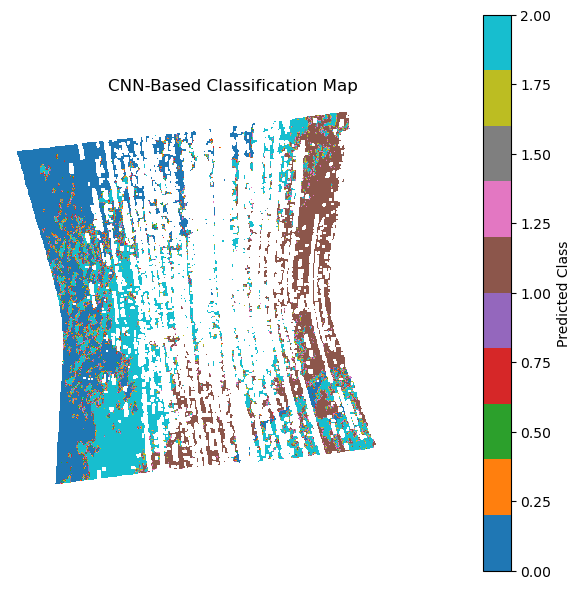

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(prediction_map, cmap='tab10')
plt.title("CNN-Based Classification Map")
plt.colorbar(label="Predicted Class")
plt.axis('off')
plt.tight_layout()
plt.show()
